In [69]:
import numpy as np
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
from scipy import signal
import time
from matplotlib.widgets import Slider, TextBox

In [72]:
class Point_Cloud():
    def __init__(self, path, frame_size=60, eps=0.1, min_samples=5, max=3, min=0.3):
        self.path = path                    # point cloud data path
        self.frame_size = frame_size        # num of points per frame
        self.data_frames = None             # num_of_frames x 3 x frame_size
        self.data_all = None                # 3 x num_of_points
        self.all_cluster = None             # clusetrs
        self.all_cluster_by_frame = None    # clusters x num_of_frames

        self.parse_data(max, min)
        self.run_DBSCAN(eps=eps, min_samples=min_samples)

    
    def parse_data(self, max, min):
        '''
            parse point cloud data into dicts
                max: max distance in meters to be considered as a valid signal
                min: min distance in meters to be considered as a valid signal
        '''
        # start = time.time()
        # read data from file
        print("Loading Point Cloud Data...")
        with open(self.path, "r") as f:
            dataRaw = f.read()
            f.close()
        
        # parse data
        point_data = {"pointID":[], "x":[], "y":[], "z":[]}
        for data in dataRaw.split("---\n")[:-1]:
            line = data.split("\n")
            if abs(float(line[7].split(": ")[1])) < max and abs(float(line[7].split(": ")[1])) > min:
                # if abs(float(line[8].split(": ")[1])) < max and abs(float(line[8].split(": ")[1])) > min:
                    # if abs(float(line[9].split(": ")[1])) < max and abs(float(line[9].split(": ")[1])) > min:
                        point_data["pointID"].append(float(line[6].split(": ")[1]) )
                        point_data["x"].append(float(line[7].split(": ")[1]) )
                        point_data["y"].append(float(line[8].split(": ")[1]) )
                        point_data["z"].append(float(line[9].split(": ")[1]) )

        for key in point_data.keys():
            print(key, len(point_data[key]))

        # organize data into frames
        data_frames = []
        for f_num in np.arange(0, len(point_data["x"])//self.frame_size):
            s = f_num*self.frame_size
            e = (f_num+1)*self.frame_size
            frame = [point_data["x"][s:e], point_data["y"][s:e], point_data["z"][s:e]]
            data_frames.append(frame)

        self.data_frames = np.array(data_frames)
        self.data_all = np.concatenate(self.data_frames.T, axis=1).T
        
        print("data_frames shape:", np.shape(self.data_frames))
        print("Loading Success!")
        # end = time.time()
        # print("parse:", end - start)
    
    def run_DBSCAN(self, eps=0.1, min_samples=5):
        '''
            run DBSCAN on point cloud to find clusters 
                eps: max distance between two samples to be considered in same cluster
                min_samples: min cluster size
        '''
        # start = time.time()
        self.all_cluster = np.array(DBSCAN(eps=eps, min_samples=min_samples).fit_predict(self.data_all))

        self.all_cluster_by_frame = []
        for i, frame in enumerate(self.data_frames):
            cluster = np.array(DBSCAN(eps=eps, min_samples=min_samples).fit_predict(frame.T))
            self.all_cluster_by_frame.append(cluster)
        print("Clustering Success!")
        # end = time.time()
        # print("DBSCAN:", end - start)
        

    def get_cluster_items(self, cluster_idx=0, frame_id=None):
        '''
            get specific cluster by id and/or by frame id
        '''
        if frame_id != None:
            idx = np.argwhere(self.all_cluster_by_frame[frame_id] == cluster_idx).T
            return (self.data_frames[frame_id]).T[idx][0]
        else:
            idx = np.argwhere(self.all_cluster == cluster_idx).T
            return self.data_all[idx][0]
    
    def get_cluster(self, frame_id=None):
        '''
            get all cluster of a frame
        '''
        out_cluster = None
        if frame_id != None:
            out_cluster = self.all_cluster_by_frame[frame_id]
        else:
            out_cluster = self.all_cluster
        return out_cluster

    def label2color(self, labels):
        ''' 
            assign color labels to clusters
        '''
        color = ["b", "g", "r", "c", "m", "y", "k", "silver"]
        out = []
        for i,l in enumerate(labels):
            out.append(color[l])
        return out
    
    def get_label_analysis(self, lables):
        ''' 
            find number of points in a cluster group by colors
        '''
        num = np.max(lables) + 1
        print("\tnoises: ",  len(np.argwhere(lables == -1)), len(np.argwhere(lables == -1))/len(lables))

        color = ["b", "g", "r", "c", "m", "y", "k", "silver"]
        for i in range(num):
            print("\t", i, color[i], len(np.argwhere(lables == i)), len(np.argwhere(lables == i))/len(lables)) 
    
    def plot_cluster(self, cluster_frame, frame_id, cluster_id):
        ''' 
            plot a cluster given cluster id and frame id
        '''
        # fig = plt.figure(figsize=plt.figaspect(0.5))
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        point_scatter = ax.scatter3D(cluster_frame[0], cluster_frame[1], cluster_frame[2], cmap="Greens")
        # ax.scatter3D([0], [0], [0], linewidths = 10, c = "r")

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_title('Clsuter {} in frame {}'.format(cluster_id, frame_id))

        ax.view_init(elev=30, azim=135)

        ax = fig.add_subplot(1, 2, 2)
        ax.scatter(cluster_frame[1], cluster_frame[2])
        ax.set_xlabel("y")
        ax.set_ylabel("z")
        plt.tight_layout()
        

    def plot_points(self, frame_id=0, cluster_id=0, max=None, min=None, remove_ids=None):
        ''' 
            plot all clusters in a given frame 
                max: max distance
                min: min distance
                remove_id: cluster to remove by id
        '''
        # start = time.time()
        clustering = self.get_cluster(frame_id)

        colors = self.label2color(clustering)
        cur_cluster = self.data_frames[frame_id]
        remaining_clusters = clustering
        if remove_ids != None:
            remain_idxs = []
            for idx, c in enumerate(clustering):
                if c not in remove_ids:
                    remain_idxs.append(idx)
            cur_cluster = cur_cluster.T[remain_idxs].T
            colors = np.array(colors).T[remain_idxs].T
            remaining_clusters = np.array(remaining_clusters).T[remain_idxs].T

        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter3D(cur_cluster[0], cur_cluster[1], cur_cluster[2], c=colors)
        ax.scatter3D([0], [0], [0], linewidths = 10, c = "r")
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_title("All clusters of frame {}".format(frame_id))

        ax.view_init(elev=30, azim=135)
        

        print("Cluster Pred: ")
        self.get_label_analysis(clustering)

        cluster_idxs = np.argwhere(remaining_clusters == cluster_id).flatten()
        self.plot_cluster(cur_cluster.T[cluster_idxs].T, frame_id, cluster_id)

        # end = time.time()
        # print("plot:", end - start)
    
    def plot_interactive(self, frame_id=0):

        clustering = self.get_cluster(frame_id)

        colors = self.label2color(clustering)
        cur_cluster = self.data_frames[frame_id]

        fig = plt.figure(figsize=(5, 5))
        ax = plt.axes(projection='3d')
        ax.scatter3D(cur_cluster[0], cur_cluster[1], cur_cluster[2], c=colors)
        ax.scatter3D([0], [0], [0], linewidths = 10, c = "r")
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_title("All clusters of frame {}".format(frame_id))

        ax_ts = plt.axes([0.25, 0.15, 0.40, 0.03])
        ts_num = Slider(ax_ts, 'frame_id', 0, len(cur_cluster), 1)

        ax.view_init(elev=30, azim=135)

        def get_num_slider(val):
            ax.clear()
            clustering = self.get_cluster(val)
            colors = self.label2color(clustering)
            cur_cluster = self.data_frames[val]
            ax.scatter3D(cur_cluster[0], cur_cluster[1], cur_cluster[2], c=colors)
            ax.scatter3D([0], [0], [0], linewidths = 10, c = "r")

        ts_num.on_changed(get_num_slider)
        plt.show()

b : blue.
g : green.
r : red.
c : cyan.
m : magenta.
y : yellow.
k : black.
w : white

Loading Point Cloud Data...
pointID 30510
x 30510
y 30510
z 30510
data_frames shape: (508, 3, 60)
Loading Success!
parse: 0.1701962947845459
Clustering Success!
DBSCAN: 3.881438970565796
Cluster Pred: 
	noises:  17 0.2833333333333333
	 0 b 13 0.21666666666666667
	 1 g 5 0.08333333333333333
	 2 r 6 0.1
	 3 c 11 0.18333333333333332
	 4 m 8 0.13333333333333333
plot: 0.33095693588256836


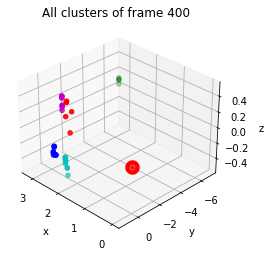

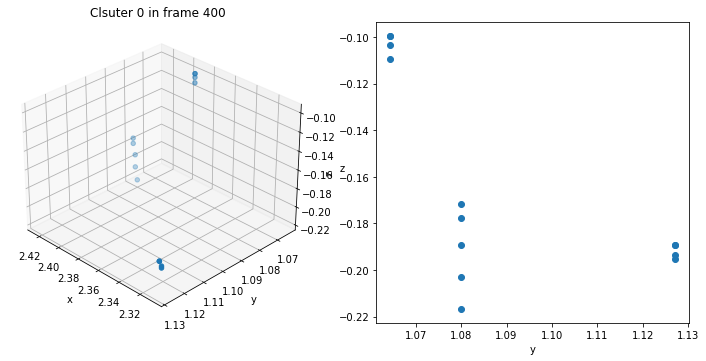

In [75]:
# file_name = "xin_standing_still_1min_1.93m.txt"
file_name = "xin_and_daniel_2_person_standing_still_1.93m.txt"
# file_name = "xin_moving_back_and_forth_1m-1.93m.txt"
pc_2 = Point_Cloud(path=file_name, frame_size=60, eps=0.4, min_samples=5, max=4, min=0.3)
pc_2.plot_points(frame_id=400, cluster_id=0, remove_ids=[-1])

In [255]:
abs(pc_2.get_cluster_items(frame_id=30, cluster_idx=0))

array([[1.80664062, 1.04296875, 0.0625    ],
       [1.93945312, 0.50195312, 0.0390625 ],
       [1.99609375, 0.44726562, 0.00390625],
       [2.04882812, 0.390625  , 0.02929688],
       [2.04882812, 0.33203125, 0.46484375],
       [2.26171875, 0.14648438, 0.54492188],
       [2.3671875 , 0.1484375 , 0.08203125],
       [2.40429688, 0.15039062, 0.15429688],
       [1.88476562, 0.55273438, 0.00585938],
       [1.92382812, 0.56445312, 0.02148438],
       [1.94335938, 0.63867188, 0.0234375 ],
       [1.90625   , 0.84765625, 0.03515625],
       [2.3671875 , 0.07421875, 0.12695312],
       [2.40625   , 0.07617188, 0.17382812],
       [1.8984375 , 0.49023438, 0.09179688],
       [1.94140625, 0.50195312, 0.00976562],
       [1.99414062, 0.44726562, 0.09570312],
       [1.99804688, 0.59765625, 0.41992188],
       [2.07617188, 0.54296875, 0.31640625],
       [2.34960938, 0.1484375 , 0.30078125],
       [2.39648438, 0.15039062, 0.23828125],
       [1.88476562, 0.55273438, 0.02929688],
       [1.

In [3]:
# file_name = "/Users/xin/Desktop/millimeter wave/code_exp/cloud_point/stationary_box_facing_up_1m.txt"
# pc = Point_Cloud(path=file_name, frame_size=60, eps=0.1, min_samples=5)
# pc.plot_points(frame_id=6, cluster_idx=1)

In [6]:
class Vital_Signal():
    def __init__(self, data, fs=60):
        self.data = data
        self.fs = fs


    def get_vital_signal(self, low=0.85, high=1.5, nperseg=10):
        f, t, Sxx = signal.spectrogram(self.data, fs=self.fs, nperseg=nperseg)
        
        idx = np.argwhere(np.logical_and(f>=low, f<=high))
        heart_f = f[idx].squeeze()
        heart_Sxx = Sxx[idx].squeeze()

        plt.pcolormesh(t, heart_f, heart_Sxx, shading='nearest')
        # plt.title("Heartneat")
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()

        


In [8]:
me = pc_2.get_cluster_items(frame_id=None, cluster_idx=0)
np.shape(me)

(8761, 3)

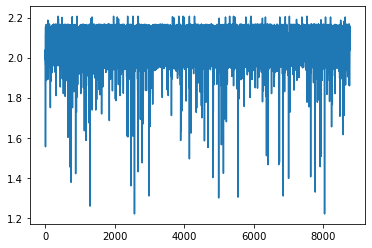

In [14]:
X = me[:,0]

plt.plot(np.arange(len(X)), X )

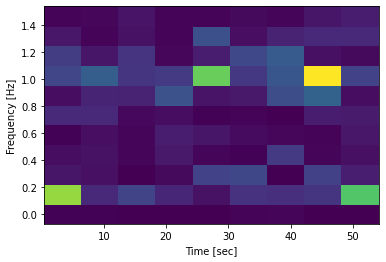

In [24]:
vs = Vital_Signal(X, fs=150)
vs.get_vital_signal(low=0.0, high=1.5, nperseg=1024)